In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
path = "images-photographes"

In [3]:
def load_dataset(dir_sc, images_per_class=None):
    inames = []
    ilabels = []
    cnames = sorted(os.listdir(dir_sc))
    for ilabel, cl in enumerate(cnames):
        dir_cl = os.path.join(dir_sc, cl)
        for iname in os.listdir(dir_cl)[:images_per_class]:
            inames.append(os.path.join(cl, iname))
            ilabels.append(ilabel)
    ilabels = np.array(ilabels)
    return inames, ilabels, cnames


# Sifts Computation

In [4]:
def ComputeSift(I):
    gray= cv.cvtColor(I,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    img = cv.drawKeypoints(gray,kp,I,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #cv.imwrite(os.path.join('Sifts',p), img)
    #print(os.path.join('Sifts',p))
    #cv.imshow('First Image',img)
    #cv.waitKey()
    #cv.destroyAllWindows()
    return kp, des

In [5]:
def ComputeSiftDataset(inames):
    keypoints = []
    descriptors = []
    for x in inames:
        p = os.path.join(path, x)
        #print(p)
        img = cv.imread(p)
        kp, des = ComputeSift(img)
        keypoints.append(kp)
        descriptors.append(des)
    
    return keypoints, descriptors
        
    

In [6]:
inames, ilabels, class_names = load_dataset(path)

In [7]:
class_names

['daido-moriyama',
 'dorothea-lange',
 'felix-nadar',
 'henri-cartier-bresson',
 'irving-penn',
 'malik-sidibe',
 'marc-riboud',
 'seidou-keita',
 'shomei-tomatsu',
 'walter-evans']

In [8]:
ilabels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [9]:
keypoints, descriptors = ComputeSiftDataset(inames)

In [10]:
descriptors[0]

array([[ 4.,  0.,  0., ...,  0.,  0.,  1.],
       [ 9.,  0.,  0., ...,  0.,  0.,  2.],
       [10.,  0.,  0., ...,  0.,  4.,  6.],
       ...,
       [15.,  9., 25., ...,  0.,  0.,  0.],
       [ 2.,  1.,  0., ...,  0.,  0.,  0.],
       [34.,  3.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [22]:
from sklearn.cluster import KMeans

In [23]:
def compute_split(length, seed=1337, pc=0.80):
    train_ids = np.random.RandomState(seed=seed).choice(
        length,
        size=int(length * pc),
        replace=False)
    test_ids = np.array(list(set(np.arange(length)) - set(train_ids)))
    return train_ids, test_ids

In [24]:
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    zeros_vect = np.zeros((128))
    kmeans = KMeans(n_clusters=n_clusters).fit(sift)
    centers = kmeans.cluster_centers_
    np.append(centers, zeros_vect)
    vdict = centers

    return vdict

In [25]:
vdict = compute_visual_dict(descriptors)
vdict

array([[ 9.060976 , 31.731705 , 84.231705 , ..., 44.939026 , 56.97561  ,
        15.804878 ],
       [16.634148 ,  8.260161 ,  7.097563 , ..., 20.764225 , 10.959349 ,
        10.195123 ],
       [36.809525 , 30.753967 , 16.333332 , ..., 20.198412 , 16.88095  ,
        19.579367 ],
       ...,
       [15.415839 , 11.029703 , 11.574259 , ..., 16.138613 , 23.099007 ,
        19.58416  ],
       [17.678898 ,  6.91743  ,  7.4403667, ..., 15.211008 , 12.844036 ,
        12.577982 ],
       [21.042017 , 10.050418 ,  9.310924 , ..., 22.77311  ,  9.2521   ,
         9.218488 ]], dtype=float32)

In [26]:
vdict.shape

(1000, 128)

# Visual Dictionary

In [27]:
def display_images(images):
    n_images,w,h = images.shape
    n = int(np.ceil(np.sqrt(n_images)))
    im = np.zeros((n*w, n*h))
    for k in range(n_images):
        i = k % n
        j = k // n
        im[i*w:i*w+w, j*h:j*h+h] = images[k]

    plt.figure(figsize=(0.7*n,0.7*n))
    plt.gray()
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [28]:
def dense_sampling(im, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    return x, y

In [29]:
def auto_padding(im, k=16, s=8):
    w, h = im.shape
    x = np.arange(0, w, s)
    y = np.arange(0, h, s)
    # last region could be smaller
    last_r = im[x[-1]:x[-1]+k, y[-1]:y[-1]+k]
    if last_r.shape == (k, k):
        return im
    dif_w = k - last_r.shape[0]
    dif_h = k - last_r.shape[1]
    n_im = np.zeros((w+dif_w, h+dif_h))
    id_w = dif_w // 2
    id_h = dif_h // 2
    n_im[id_w:id_w+w, id_h:id_h+h] = im
    return n_im

In [30]:
def compute_regions(im, k=16, s=8):
    x, y = dense_sampling(im) # before padding
    im = auto_padding(im)
    images = np.zeros((x.shape[0], y.shape[0], k, k))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            images[i,j] = im[x[i]:x[i]+k, y[j]:y[j]+k]
    return images

In [31]:
def get_regions(inames):
    vdpaths = [os.path.join(path, iname) for iname in inames]

    regions = []
    for p in vdpaths:
        im = cv.imread(p)
        gray= cv.cvtColor(im,cv.COLOR_BGR2GRAY)
        regions.append(compute_regions(gray))

    k = regions[0].shape[-1]
    n_reg = np.array([r.shape[0]*r.shape[1] for r in regions])
    cs_reg = np.cumsum(n_reg)

    regions = [r.reshape(-1, k, k) for r in regions]
    regions = np.concatenate(regions, axis=0)

    return regions

In [32]:
indexes = np.random.randint(0, len(inames), 30)
sifts = [descriptors[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

In [33]:
_, sifts_chosen = ComputeSiftDataset(chosen_inames)

In [34]:
regions = get_regions(chosen_inames)

In [35]:
sift = [s.reshape(-1, sifts_chosen[0].shape[-1]) for s in sifts_chosen]
sift = np.concatenate(sift, axis=0)

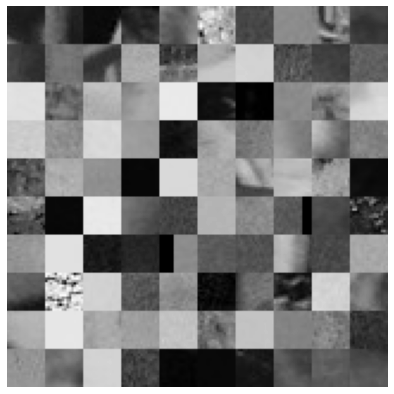

In [36]:
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

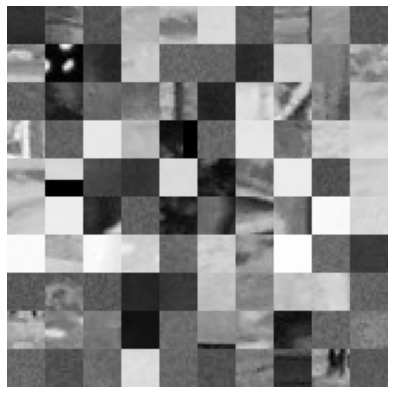

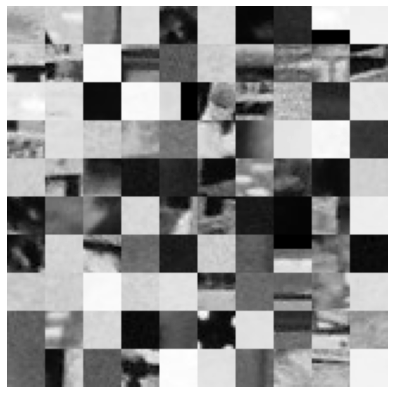

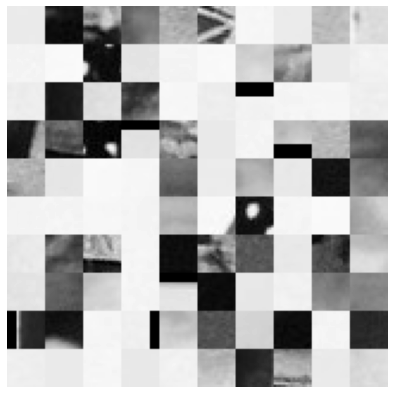

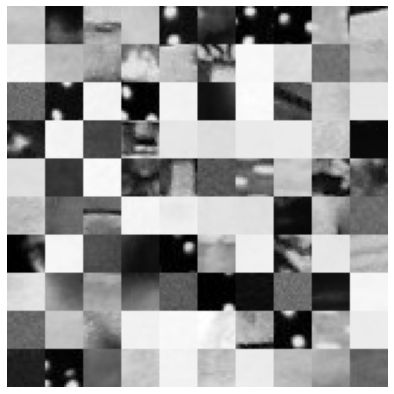

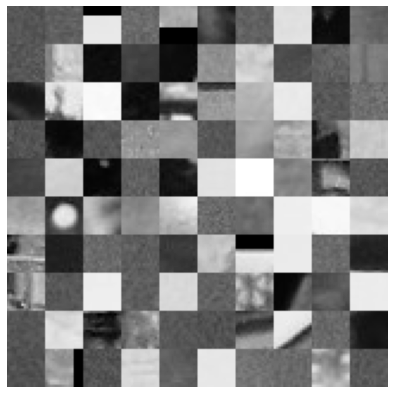

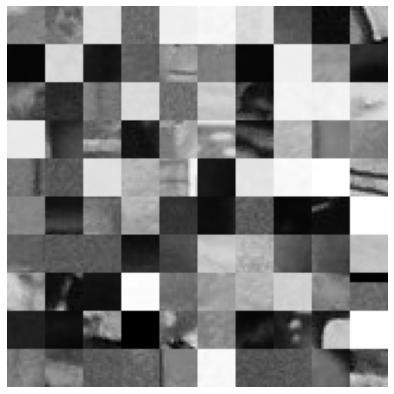

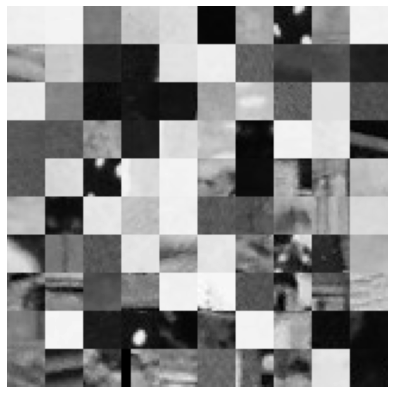

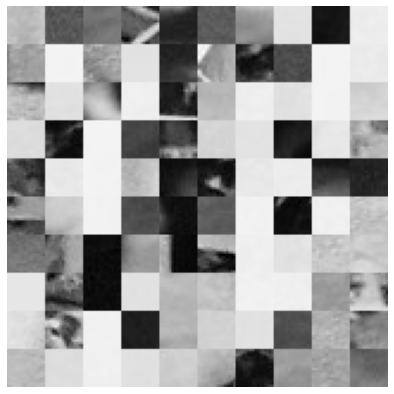

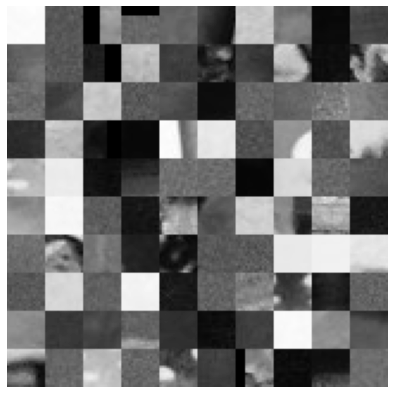

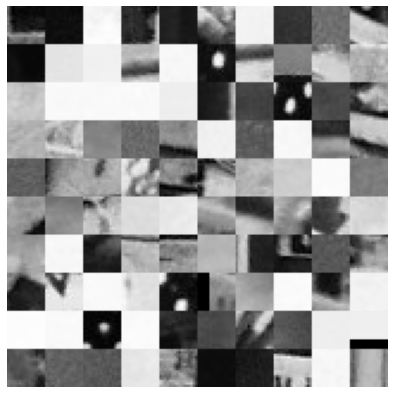

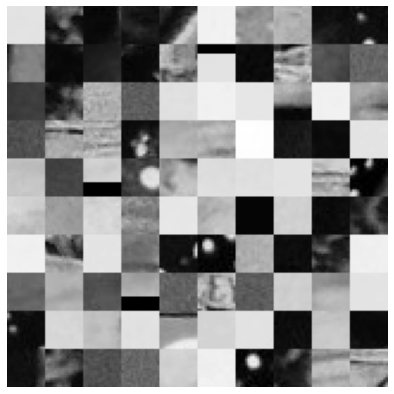

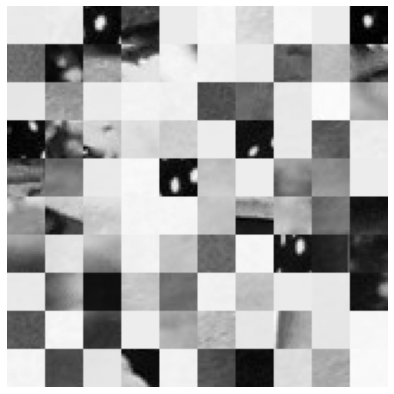

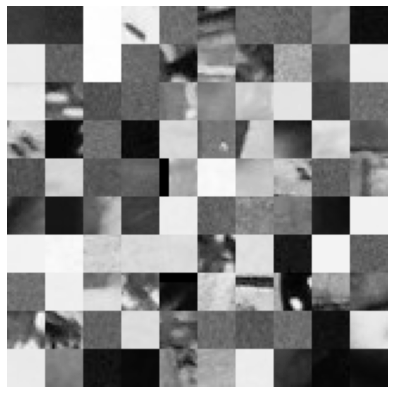

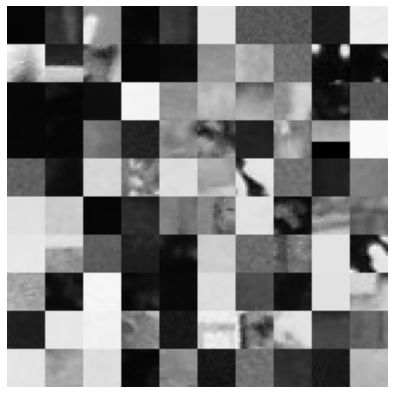

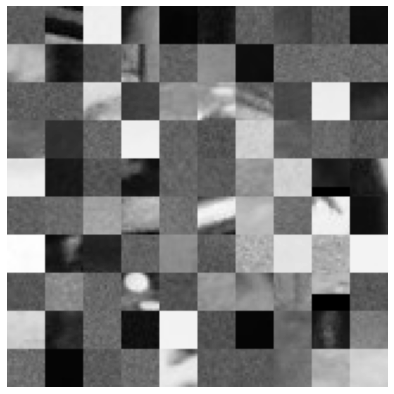

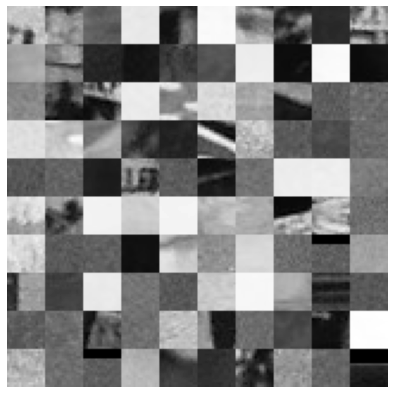

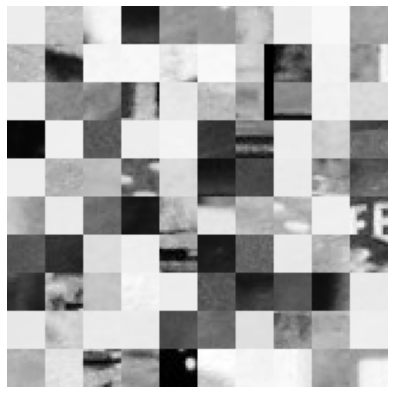

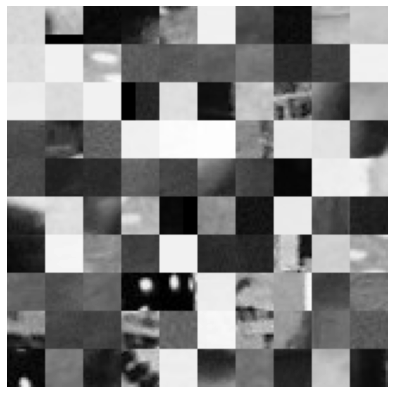

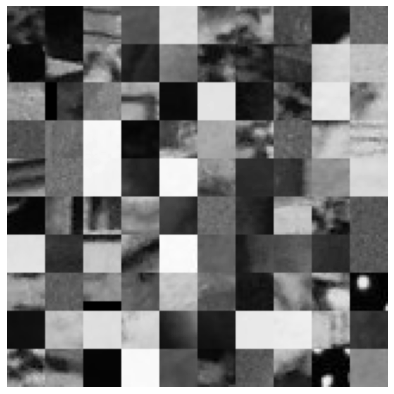

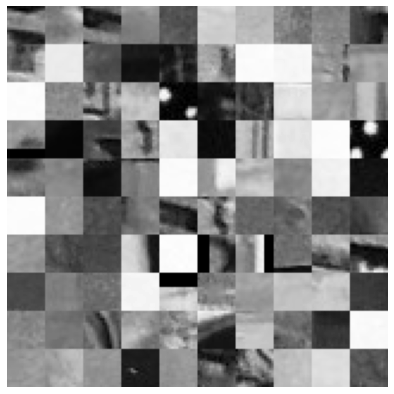

In [37]:
centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  dist = ((sift - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions

# Bag of Features

In [38]:
def compute_feats(vdict, descriptors):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = np.array(descriptors).reshape(-1, 128)  # (N, 128)
    #print(sifts.shape)
    feats = np.zeros(vdict.shape[0])
    
    distances = distance_matrix(sifts, vdict)
    best_feature = np.argmin(distances, axis=1)
    for i in best_feature:
      feats[i]+=1
    
    norm = np.linalg.norm(feats, ord=2)
    feats = feats/norm

    return feats

In [39]:
from numpy import asarray
from numpy import savez_compressed



In [40]:
idx = len(inames)

dataset_feats = []
for id in range(len(inames)):
    print(id)
    iname = inames[id]
    ipath = os.path.join(path, iname)
    im = cv.imread(ipath)
    _,sift = ComputeSift(im)
   
    sift = (sift * 255).astype('uint8')
    
    gray= cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    regions = compute_regions(gray)
    feats = compute_feats(vdict, sift)
    print(feats.shape)
    dataset_feats.append(feats)
    #display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here
savez_compressed('bow.npz', dataset_feats) 

0
(1000,)
1
(1000,)
2
(1000,)
3
(1000,)
4
(1000,)
5
(1000,)
6
(1000,)
7
(1000,)
8
(1000,)
9
(1000,)
10
(1000,)
11
(1000,)
12
(1000,)
13
(1000,)
14
(1000,)
15
(1000,)
16
(1000,)
17
(1000,)
18
(1000,)
19
(1000,)
20
(1000,)
21
(1000,)
22
(1000,)
23
(1000,)
24
(1000,)
25
(1000,)
26
(1000,)
27
(1000,)
28
(1000,)
29
(1000,)
30
(1000,)
31
(1000,)
32
(1000,)
33
(1000,)
34
(1000,)
35
(1000,)
36
(1000,)
37
(1000,)
38
(1000,)
39
(1000,)
40
(1000,)
41
(1000,)
42
(1000,)
43
(1000,)
44
(1000,)
45
(1000,)
46
(1000,)
47
(1000,)
48
(1000,)
49
(1000,)
50
(1000,)
51
(1000,)
52
(1000,)
53
(1000,)
54
(1000,)
55
(1000,)
56
(1000,)
57
(1000,)
58
(1000,)
59
(1000,)
60
(1000,)
61
(1000,)
62
(1000,)
63
(1000,)
64
(1000,)
65
(1000,)
66
(1000,)
67
(1000,)
68
(1000,)
69
(1000,)
70
(1000,)
71
(1000,)
72
(1000,)
73
(1000,)
74
(1000,)
75
(1000,)
76
(1000,)
77
(1000,)
78
(1000,)
79
(1000,)
80
(1000,)
81
(1000,)
82
(1000,)
83
(1000,)
84
(1000,)
85
(1000,)
86
(1000,)
87
(1000,)
88
(1000,)
89
(1000,)
90
(1000,)
91
(1000,

In [46]:
dataset_feats[2].shape

(1000,)

In [48]:
np.array(dataset_feats).shape

(280, 1000)

In [50]:
dataX = np.array(dataset_feats)
dataY = ilabels

In [51]:
dataX.shape, dataY.shape

((280, 1000), (280,))

In [53]:
{c: nb for c, nb in enumerate(np.bincount(dataY))}

{0: 32, 1: 18, 2: 27, 3: 45, 4: 38, 5: 33, 6: 35, 7: 13, 8: 13, 9: 26}

In [55]:
test_ratio = 0.2
validation_ratio = 0.125

X_train_full, X_test, y_train_full, y_test = train_test_split(dataX, dataY, test_size=test_ratio, shuffle=True)

In [56]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_full, y_train_full, test_size=validation_ratio, shuffle=True)

In [71]:
model = SVC(C=50, kernel='sigmoid', max_iter=10000)
# Fit on sub-train set
# TODO
model.fit(X_train, y_train)
# Evaluate on val set
# TODO
y_hat_validation = model.predict(X_validation)
acc = accuracy_score(y_true=y_validation, y_pred=y_hat_validation)

In [72]:
print(f'--> accuracy = {acc}')

--> accuracy = 0.21428571428571427


In [85]:
model = SVC()
distribution=dict(C=np.linspace(10, 1000, 100),
                  kernel=['linear'],
                  gamma=['scale', 'auto'],
                  class_weight=[None, 'balanced'],
                  decision_function_shape=['ovo', 'ovr']
                  )
clf = RandomizedSearchCV(model, distribution, n_jobs=-1, verbose=1)
search = clf.fit(X_train_full, y_train_full)
search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'kernel': 'linear',
 'gamma': 'auto',
 'decision_function_shape': 'ovo',
 'class_weight': None,
 'C': 110.0}

In [86]:
clf.best_score_

0.2546464646464646